# SMC with Importance sampling, resampling, and linear regression (log c_L)

100%|██████████| 1000/1000 [01:15<00:00, 13.19it/s]

Final estimate of μ: 2.6393


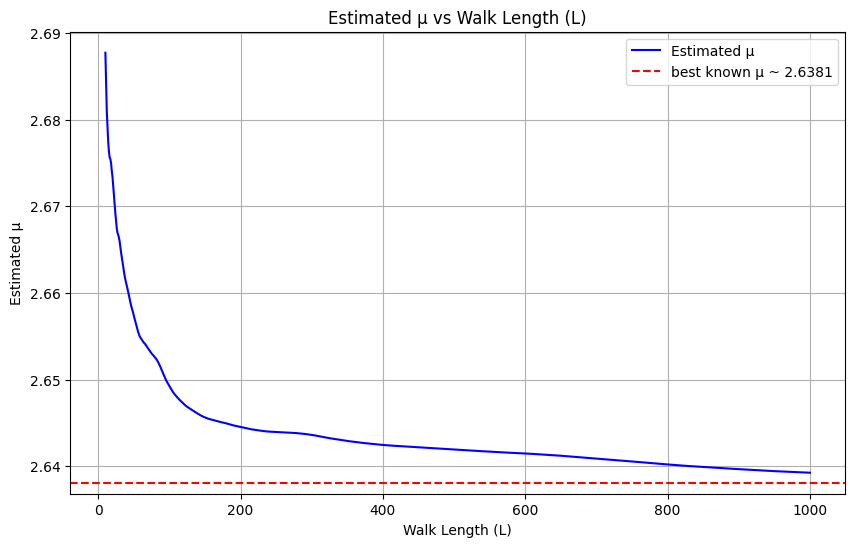

In [4]:
import random
import numpy as np
import statsmodels.api as sm
from tqdm import tqdm
import matplotlib.pyplot as plt

def estimate_mu(N, max_L):
    # Initialize N walks at L=0 (single point)
    walks = [[(0, 0)] for _ in range(N)]
    log_c = 0.0  # log(c_0) = 0 since c_0=1

    # Lists for regression data: y = (log c_L)/L, x1 = 1/L, x2 = (log L)/L
    y_list, x1_list, x2_list = [], [], []
    mu_estimates = []  # To store intermediate mu estimates
    L_values = []      # To store corresponding L values

    for step in tqdm(range(max_L)):
        new_walks, weights = [], []
        current_L = step + 1  # Current L after extension

        # Extend each walk from L to L+1
        for path in walks:
            x, y = path[-1]
            neighbors = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]
            valid = [n for n in neighbors if n not in path]
            m = len(valid)

            if m > 0:
                new_path = path + [random.choice(valid)]
                weight = m
            else:
                new_path = path  # Trapped
                weight = 0

            new_walks.append(new_path)
            weights.append(weight)

        # Calculate ratio c_{L+1}/c_L (average weight)
        r_L = np.mean(weights)
        if r_L <= 0:
            break  # All walks trapped

        log_c += np.log(r_L)

        # Store regression data
        y = log_c / current_L
        x1 = 1 / current_L
        x2 = np.log(current_L) / current_L
        y_list.append(y)
        x1_list.append(x1)
        x2_list.append(x2)

        # Resample walks based on weights
        total_weight = sum(weights)
        if total_weight > 0:
            probs = [w / total_weight for w in weights]
            indices = np.random.choice(len(new_walks), size=N, p=probs)
            walks = [new_walks[i] for i in indices]
        else:
            break  # All walks trapped

        # Perform regression up to current_L to estimate mu
        if current_L >= 10:  # Start estimating mu after some steps
            X = np.column_stack((x1_list, x2_list, np.ones_like(x1_list)))
            model = sm.OLS(y_list, X)
            results = model.fit()
            log_mu = results.params[2]  # Intercept term is log(mu)
            mu_estimates.append(np.exp(log_mu))
            L_values.append(current_L)

    # Final regression to estimate mu
    X = np.column_stack((x1_list, x2_list, np.ones_like(x1_list)))
    model = sm.OLS(y_list, X)
    results = model.fit()
    log_mu = results.params[2]  # Intercept term is log(mu)
    mu_final = np.exp(log_mu)

    return mu_final, L_values, mu_estimates

# Parameters
N = 1000
max_L = 1000

# Estimate mu and get intermediate values
mu_final, L_values, mu_estimates = estimate_mu(N, max_L)
print(f"Final estimate of μ: {mu_final:.4f}")

# Plot mu estimates vs L
plt.figure(figsize=(10, 6))
plt.plot(L_values, mu_estimates, 'b-', label='Estimated μ')
plt.axhline(y=2.6381, color='r', linestyle='--', label=f'best known μ ~ 2.6381')
plt.xlabel('Walk Length (L)')
plt.ylabel('Estimated μ')
plt.title('Estimated μ vs Walk Length (L)')
plt.legend()
plt.grid(True)
plt.show()

Additional print of c_L values

In [9]:
def estimate_mu(N, max_L):
    walks = [[(0, 0)] for _ in range(N)]
    log_c = 0.0
    var_log_c = 0.0
    log_results = []  # Changed variable name to avoid conflict
    
    report_L = [1] + list(range(50, max_L+1, 50))
    
    y_list, x1_list, x2_list = [], [], []
    mu_estimates = []
    L_values = []

    for step in tqdm(range(max_L)):
        current_L = step + 1
        
        # SMC logic
        new_walks, weights = [], []
        for path in walks:
            x, y = path[-1]
            neighbors = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]
            valid = [n for n in neighbors if n not in path]
            m = len(valid)
            
            new_walks.append(path + [random.choice(valid)] if m > 0 else path)
            weights.append(m)

        valid_weights = [w for w in weights if w > 0]
        if not valid_weights:
            break

        r_L = np.mean(weights)
        var_r_L = np.var(weights, ddof=1) / N
        log_r_L = np.log(r_L)
        
        var_log_r_L = var_r_L / (r_L ** 2) if r_L > 0 else 0
        var_log_c += var_log_r_L
        log_c += log_r_L

        if current_L in report_L:
            std_error = np.sqrt(var_log_c)
            rel_error = std_error / abs(log_c) if log_c != 0 else 0
            log_results.append((current_L, log_c, std_error, rel_error))  # Using log_results

        # Regression
        y = log_c / current_L
        x1 = 1 / current_L
        x2 = np.log(current_L) / current_L
        
        y_list.append(y)
        x1_list.append(x1)
        x2_list.append(x2)

        if current_L >= 10:
            X = np.column_stack((x1_list, x2_list, np.ones_like(x1_list)))
            model = sm.OLS(y_list, X)
            regression_results = model.fit()  # Renamed to avoid conflict
            mu_estimates.append(np.exp(regression_results.params[2]))
            L_values.append(current_L)

        # Resample
        total_weight = sum(weights)
        if total_weight > 0:
            probs = [w / total_weight for w in weights]
            walks = [new_walks[i] for i in np.random.choice(len(new_walks), size=N, p=probs)]
        else:
            break

    return log_results, L_values, mu_estimates  # Return log_results instead

log_results, L_values, mu_estimates = estimate_mu(N=1000, max_L=1000)

print("L\tln(c_L)\t\tStd Error\tRelative Error")
for L, ln_c, std_err, rel_err in log_results:
    print(f"{L}\t{ln_c:.4e}\t{std_err:.4e}\t{rel_err:.4e}")

100%|██████████| 1000/1000 [00:38<00:00, 25.84it/s]

L	ln(c_L)		Std Error	Relative Error
1	1.3863e+00	0.0000e+00	0.0000e+00
50	4.9928e+01	4.8290e-02	9.6719e-04
100	9.8748e+01	7.0762e-02	7.1659e-04
150	1.4734e+02	8.8345e-02	5.9959e-04
200	1.9607e+02	1.0269e-01	5.2377e-04
250	2.4474e+02	1.1539e-01	4.7149e-04
300	2.9330e+02	1.2687e-01	4.3257e-04
350	3.4194e+02	1.3737e-01	4.0174e-04
400	3.9024e+02	1.4748e-01	3.7792e-04
450	4.3868e+02	1.5696e-01	3.5779e-04
500	4.8723e+02	1.6563e-01	3.3993e-04
550	5.3581e+02	1.7394e-01	3.2462e-04
600	5.8411e+02	1.8230e-01	3.1210e-04
650	6.3260e+02	1.8989e-01	3.0017e-04
700	6.8087e+02	1.9760e-01	2.9022e-04
750	7.2940e+02	2.0471e-01	2.8066e-04
800	7.7801e+02	2.1134e-01	2.7165e-04
850	8.2663e+02	2.1790e-01	2.6360e-04
900	8.7504e+02	2.2433e-01	2.5636e-04
950	9.2347e+02	2.3071e-01	2.4983e-04
1000	9.7205e+02	2.3686e-01	2.4367e-04


# SMC with Importance sampling and resampling (with c_L)

 71%|███████   | 710/1000 [00:31<00:26, 10.88it/s]

 Switching to log(c_L) at L = 710 due to overflow risk


 73%|███████▎  | 728/1000 [00:33<00:25, 10.60it/s]C:\Users\User\AppData\Local\Temp\ipykernel_23840\3016189812.py:58: RuntimeWarning: overflow encountered in exp
  c_L_values.append((current_L, np.exp(log_c_L)))  # Approximate c_L from log
100%|██████████| 1000/1000 [00:59<00:00, 16.89it/s]


Final estimate of μ (adaptive c_L): 2.6469


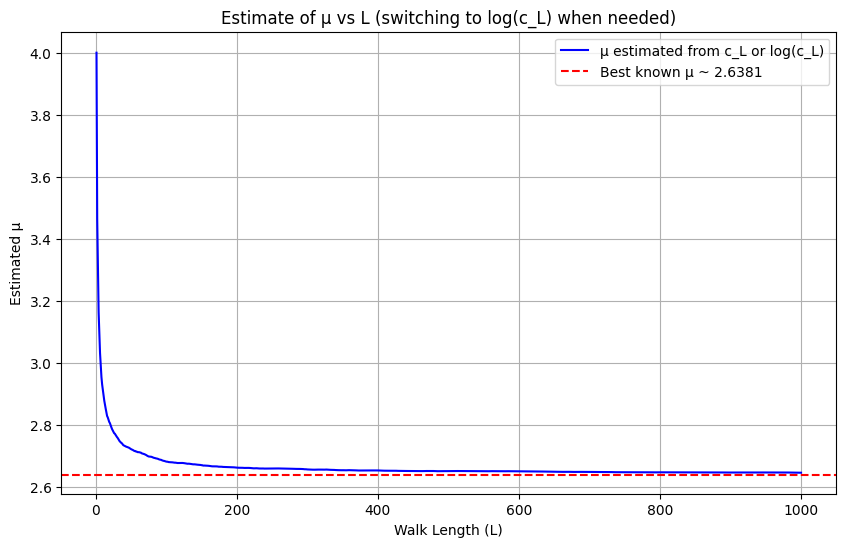

In [3]:
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def estimate_mu_safe(N, max_L, overflow_threshold=1e300):
    walks = [[(0, 0)] for _ in range(N)]
    c_L = 1.0
    log_c_L = 0.0
    using_log = False

    c_L_values = [(0, c_L)]
    mu_estimates = []
    L_values = []

    for step in tqdm(range(max_L)):
        current_L = step + 1
        new_walks, weights = [], []

        for path in walks:
            x, y = path[-1]
            neighbors = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]
            valid = [n for n in neighbors if n not in path]
            m = len(valid)

            if m > 0:
                new_path = path + [random.choice(valid)]
                weight = m
            else:
                new_path = path
                weight = 0

            new_walks.append(new_path)
            weights.append(weight)

        r_L = np.mean(weights)
        if r_L <= 0:
            break

        # Update either c_L or log(c_L)
        if not using_log:
            try:
                c_L *= r_L
                if c_L > overflow_threshold:
                    using_log = True
                    log_c_L = np.log(c_L)
                    print(f" Switching to log(c_L) at L = {current_L} due to overflow risk")
            except OverflowError:
                using_log = True
                log_c_L = np.log(c_L)
                print(f" Switching to log(c_L) at L = {current_L} due to overflow error")
        else:
            log_c_L += np.log(r_L)

        # Estimate mu
        if using_log:
            mu_L = np.exp(log_c_L / current_L)
            c_L_values.append((current_L, np.exp(log_c_L)))  # Approximate c_L from log
        else:
            mu_L = c_L ** (1 / current_L)
            c_L_values.append((current_L, c_L))

        mu_estimates.append(mu_L)
        L_values.append(current_L)

        # Resample
        total_weight = sum(weights)
        if total_weight > 0:
            probs = [w / total_weight for w in weights]
            indices = np.random.choice(len(new_walks), size=N, p=probs)
            walks = [new_walks[i] for i in indices]
        else:
            break

    return mu_estimates, L_values, c_L_values

# Parameters
N = 1000
max_L = 1000

mu_estimates, L_values, c_L_values = estimate_mu_safe(N, max_L)

# Print final estimate
if L_values:
    print(f"Final estimate of μ (adaptive c_L): {mu_estimates[-1]:.4f}")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(L_values, mu_estimates, 'b-', label='μ estimated from c_L or log(c_L)')
plt.axhline(y=2.6381, color='red', linestyle='--', label='Best known μ ~ 2.6381')
plt.xlabel('Walk Length (L)')
plt.ylabel('Estimated μ')
plt.title('Estimate of μ vs L (switching to log(c_L) when needed)')
plt.grid(True)
plt.legend()
plt.show()
